# Title

## Initialisation

In [1]:
import os
import plyfile
import numpy
import matplotlib.pyplot
import pandas
import csv
import gdal
from osgeo import osr

## Data Cleaning

In [2]:
def cleanPlyFiles(directory):
        for file in os.listdir(directory):
            if file.endswith(".ply"):
                with open(directory + "/" + file, "r") as fileOpen:
                    lines = fileOpen.readlines()
                    del lines[2:9]
                    with open(directory + "_cleaned/" + file, "w") as fileNew:
                        for line in lines:
                            fileNew.write(line)
                fileNew.close()
                fileOpen.close()

In [3]:
if False: # Set to False as this needs only be run once.
    cleanPlyFiles("../data/ahn3_feature_1km")

In [4]:
if False: # Set to False as this needs only be run once.
    cleanPlyFiles("../data/ahn3_feature_100m")

## Data Import

In [5]:
terrainHeader = ["x", "y", "z", "coeff_var_z", "density_absolute_mean", "eigenv_1", "eigenv_2", "eigenv_3", "gps_time", "intensity", "kurto_z", "max_z", "mean_z", "median_z", "min_z", "perc_10", "perc_100", "perc_20", "perc_30", "perc_40", "perc_50", "perc_60", "perc_70", "perc_80", "perc_90", "point_density", "pulse_penetration_ratio", "range", "skew_z", "std_z", "var_z"]

In [6]:
def plyIntoNumpyArray(directory, gridLength, columnList):
    fileList = [s for s in os.listdir(directory) if s.endswith(".ply")]
    terrainData = numpy.empty((gridLength * len(fileList), len(columnList)))
    for i, file in enumerate(fileList):
        plydata = plyfile.PlyData.read(directory + "/" + file)
        for j, column in enumerate(columnList):
            terrainData[gridLength * i:gridLength * i + gridLength, j] = plydata.elements[0].data[column]
    return terrainData

In [7]:
terrainData1km = plyIntoNumpyArray("../data/ahn3_feature_1km_cleaned", 4, terrainHeader)

In [8]:
if False: # Set to False to speed up work with 1km data.
    terrainData100m = plyIntoNumpyArray("../data/ahn3_feature_100m_cleaned", 400, terrainHeader)

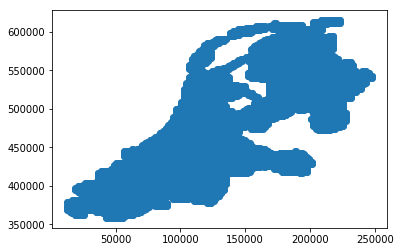

In [9]:
matplotlib.pyplot.scatter(terrainData1km[:, 0], terrainData1km[:, 1])
matplotlib.pyplot.show()

In [10]:
birdColumnHeaders = ["x_coordinaat_m", "y_coordinaat_m", "taxon_id"]
counter = 0
with open("../data/forest_nl_headers_species.csv") as f:
    birdData = numpy.empty((sum(1 for row in f), len(birdColumnHeaders)))
with open("../data/forest_nl_headers_species.csv") as f:
    reader = csv.DictReader(f)
    for row in reader:
        data = [row[column] for column in birdColumnHeaders]
        if "" not in data and "0" not in data:
            birdData[counter] = numpy.asarray(data, dtype=float)
            counter += 1
birdData = numpy.delete(birdData, numpy.s_[counter:], 0)

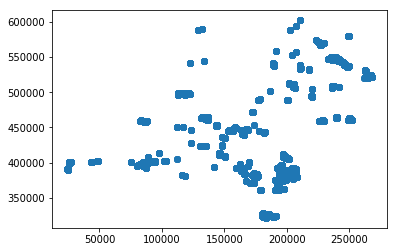

In [11]:
matplotlib.pyplot.scatter(birdData[:, 0], birdData[:, 1])
matplotlib.pyplot.show()

## Combined PLY file

In [12]:
def combinePlyFiles(directory, outputFileName):
    header = True
    with open(outputFileName + ".ply", "w") as fileNew:
        for file in os.listdir(directory):
            if file.endswith(".ply"):
                with open(directory + "/" + file, "r") as fileOpen:
                    lines = fileOpen.readlines()
                    if header:
                        header = False
                        for line in lines:
                            fileNew.write(line)
                    else:
                        for j, line in enumerate(lines):
                            if line.rstrip() == "end_header":
                                keepLines = lines[j + 1:]
                                for keepLine in keepLines:
                                    fileNew.write(keepLine)
                                break
    fileNew.close()
    fileOpen.close()

In [13]:
combinePlyFiles("../data/ahn3_feature_1km_cleaned", "../data/combined1km")

In [14]:
if False: # Set to False to speed up work with 1km data.
    combinePlyFiles("../data/ahn3_feature_100m_cleaned", "../data/combined100m")

## Compressed Numpy Dataset

In [15]:
numpy.savez_compressed("../data/compressedDatasets1km", terrainData1km=terrainData1km, birdData=birdData)

In [16]:
if False: # Set to False to speed up work with 1km data.
    numpy.savez_compressed("../data/compressedDatasets100m", terrainData100m=terrainData100m, birdData=birdData)

## GeoTiff

In [17]:
def combineTerrainFeatures(terrainData, terrainHeader):
    bands = len(terrainHeader) - 2
    listX = numpy.unique(terrainData[:, 0])
    dictX = dict(zip(listX, range(len(listX))))
    listY = numpy.unique(terrainData[:, 1])
    dictY = dict(zip(listY, range(len(listY))))
    arrays = numpy.full((bands, len(listY), len(listX)), numpy.nan)
    for terrainDatum in terrainData:
        indexX = dictX[terrainDatum[0]]
        indexY = dictY[terrainDatum[1]]
        for i in range(bands):
            arrays[i, indexY, indexX] = terrainDatum[2 + i]
    return arrays, bands, len(listY), len(listX)

In [18]:
def getGeoTransform(terrainData, nrows, ncols):
    xmin, ymin, xmax, ymax = [terrainData[:, 0].min(), terrainData[:, 1].min(), terrainData[:, 0].max(), terrainData[:, 1].max()]
    xres = (xmax - xmin) / float(ncols)
    yres = (ymax - ymin) / float(nrows)
    return (xmin, xres, 0, ymin, 0, yres)

In [19]:
def writeGeoTiff(featureArrays, terrainHeader, geoTransform, outputFileName, ncols, nrows, bands):
    output_raster = gdal.GetDriverByName('GTiff').Create(outputFileName + ".tif", ncols, nrows, bands, gdal.GDT_Float32)
    output_raster.SetGeoTransform(geoTransform)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(28992)
    output_raster.SetProjection(srs.ExportToWkt())
    for i in range(bands):
        rb = output_raster.GetRasterBand(1 + i)
        rb.SetDescription(terrainHeader[2 + i])
        rb.WriteArray(featureArrays[i])
    output_raster.FlushCache()

In [20]:
def terrainDataToGeoTiff(terrainData, terrainHeader, outputFileName):
    combinedTerrainFeatures, bands, nrows, ncols = combineTerrainFeatures(terrainData, terrainHeader)
    geoTransform = getGeoTransform(terrainData, nrows, ncols)
    writeGeoTiff(combinedTerrainFeatures, terrainHeader, geoTransform, outputFileName, ncols, nrows, bands)

In [21]:
terrainDataToGeoTiff(terrainData1km, terrainHeader, "../data/terrainData1km")

In [22]:
if False: # Set to False to speed up work with 1km data.
    terrainDataToGeoTiff(terrainData100m, terrainHeader, "../data/terrainData100m")

End of _Jupyter Notebook_.